### LSTM - Input: 'Close/Last', 'SMA', 'MACD', 'Signal_Line', 'RSI'

In [12]:
import pandas as pd
import numpy as np
# Load the data
data = pd.read_csv('Data_input_2.csv')

# Check for missing values
print(data.isnull().sum())

# Fill missing values or drop rows with missing values
data.fillna(method='ffill', inplace=True)  # forward fill
data.dropna(inplace=True)  # drop any remaining NaNs


Date           0
Close/Last     0
SMA            0
MACD           0
Signal_Line    0
RSI            0
dtype: int64


C:\Users\DELL\AppData\Local\Temp\ipykernel_20540\4163951013.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # forward fill


In [13]:
data['Date'] = pd.to_datetime(data['Date'])

# Tạo các cột phụ để sắp xếp theo năm, tháng, ngày
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# Sắp xếp DataFrame theo năm, sau đó tháng, và cuối cùng là ngày
data.sort_values(['Year', 'Month', 'Day'], inplace=True)

# Xóa các cột phụ nếu không cần thiết
data.drop(columns=['Year', 'Month', 'Day'], inplace=True)
data

,Date,Close/Last,SMA,MACD,Signal_Line,RSI
1238,2019-06-28,4660.72,4481.3010,99.321197,90.056725,61.707838
1237,2019-07-01,4766.31,4511.1155,109.460715,93.937523,67.217516
1236,2019-07-02,4747.96,4532.4645,114.693548,98.088728,71.051746
1235,2019-07-03,4773.91,4554.6995,119.556383,102.382259,71.499561
1234,2019-07-05,4757.68,4573.8110,120.709130,106.047633,77.083139
...,...,...,...,...,...,...
4,2024-05-23,10495.82,10181.2985,126.992633,71.836167,76.381399
3,2024-05-24,10549.22,10205.9780,132.541316,83.977197,74.341863
2,2024-05-28,10526.85,10230.3385,133.593631,93.900484,75.571463
1,2024-05-29,10396.40,10257.8745,122.489392,99.618265,66.767226


In [14]:
# Tính toán số lượng dòng cho từng phần
total_rows = len(data)
train_size = int(0.8 * total_rows)
val_size = int(0.1 * total_rows)
test_size = total_rows - train_size - val_size  # Đảm bảo rằng tổng số dòng vẫn bằng total_rows

# Chia DataFrame thành các tập huấn luyện, kiểm tra và kiểm định
data_train = data.iloc[:train_size]
data_val = data.iloc[train_size:train_size + val_size]
data_test = data.iloc[train_size + val_size:]

In [15]:
from sklearn.preprocessing import MinMaxScaler

# Chuẩn hóa các cột giá dựa trên tập huấn luyện và áp dụng cho tập kiểm tra và kiểm định
scaler_price = MinMaxScaler(feature_range=(-1, 1))
price_columns = ['Close/Last', 'SMA', 'MACD', 'Signal_Line', 'RSI']
data_train_copy=data_train[price_columns]
data_train[price_columns] = scaler_price.fit_transform(data_train[price_columns])
data_val[price_columns] = scaler_price.transform(data_val[price_columns])
data_test_copy=data_test[price_columns]
data_test[price_columns] = scaler_price.transform(data_test[price_columns])

# Chuyển đổi các cột pandas thành mảng NumPy
train_data = data_train[price_columns].values
val_data = data_val[price_columns].values
test_data = data_test[price_columns].values

# Hiển thị kích thước của các tập dữ liệu
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (991, 5)
Validation data shape: (123, 5)
Test data shape: (125, 5)


C:\Users\DELL\AppData\Local\Temp\ipykernel_20540\4175297681.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train[price_columns] = scaler_price.fit_transform(data_train[price_columns])
C:\Users\DELL\AppData\Local\Temp\ipykernel_20540\4175297681.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val[price_columns] = scaler_price.transform(data_val[price_columns])
C:\Users\DELL\AppData\Local\Temp\ipykernel_20540\4175297681.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [16]:
# Training data
seq_len = 30
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 0][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 0][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 0][i])
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (961, 30, 5) (961,)
Validation set shape (93, 30, 5) (93,)
Testing set shape (95, 30, 5) (95,)


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=30):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]


class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.encoder = nn.Linear(input_dim, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, src):
        src = self.encoder(src) * torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output[-1])
        return output

def prepare_data(X_train, y_train, X_val, y_val, X_test, y_test, batch_size):
    train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch.permute(1, 0, 2))
            loss = criterion(output.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                output = model(X_batch.permute(1, 0, 2))
                loss = criterion(output.squeeze(), y_batch)
                val_loss += loss.item()

        print(f'Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}')

def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch.permute(1, 0, 2))
            predictions.extend(output.squeeze().tolist())
            actuals.extend(y_batch.tolist())

    return predictions, actuals

In [18]:
input_dim = 5
d_model = 64
nhead = 8
num_encoder_layers = 3
dim_feedforward = 512
dropout = 0.1
batch_size = 32
num_epochs = 20
learning_rate = 0.0001

train_loader, val_loader, test_loader = prepare_data(X_train, y_train, X_val, y_val, X_test, y_test, batch_size)
model = TransformerModel(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)



d:\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
d:\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Train Loss: 0.09450351464892587, Validation Loss: 0.009430026092256108
Epoch 2, Train Loss: 0.02282125632618479, Validation Loss: 0.013669905873636404
Epoch 3, Train Loss: 0.014965597224692184, Validation Loss: 0.005106251376370589
Epoch 4, Train Loss: 0.014154977120098567, Validation Loss: 0.0061024703706304235
Epoch 5, Train Loss: 0.015409463731151435, Validation Loss: 0.003938369452953339
Epoch 6, Train Loss: 0.012171579720152, Validation Loss: 0.006754909176379442
Epoch 7, Train Loss: 0.01098785427729449, Validation Loss: 0.004271010868251324
Epoch 8, Train Loss: 0.010088903123452779, Validation Loss: 0.0033545996993780136
Epoch 9, Train Loss: 0.008993038558401167, Validation Loss: 0.0037287131417542696
Epoch 10, Train Loss: 0.009023088721498367, Validation Loss: 0.003152503011127313
Epoch 11, Train Loss: 0.009206740471023706, Validation Loss: 0.004098892367134492
Epoch 12, Train Loss: 0.007713079242216003, Validation Loss: 0.0031690754306813083
Epoch 13, Train Loss: 0.008

In [19]:
# Hàm để chuẩn bị dữ liệu cho dự đoán
def prepare_test_data(X_test):
    return torch.tensor(X_test, dtype=torch.float32)

# Dự đoán giá cổ phiếu
def predict_stock_price(model, X_test, scaler_price):
    model.eval()
    with torch.no_grad():
        X_test_tensor = prepare_test_data(X_test)
        predictions = model(X_test_tensor.permute(1, 0, 2))
        predicted_stock_price = predictions.squeeze().numpy()

    # Thêm các cột giá trị giả (zeros) để khớp với hình dạng mà scaler đã được huấn luyện
    predicted_stock_price_extended = np.concatenate((predicted_stock_price.reshape(-1, 1), np.zeros((predicted_stock_price.shape[0], 4))), axis=1)

    # Đảo ngược quá trình chuẩn hóa
    predicted_stock_price_scaled_back = scaler_price.inverse_transform(predicted_stock_price_extended)

    # Loại bỏ các cột giá trị giả
    predicted_stock_price = predicted_stock_price_scaled_back[:, 0]

    return predicted_stock_price

# Thực hiện dự đoán
predicted_stock_price = predict_stock_price(model, X_test, scaler_price)
# print(predicted_stock_price)

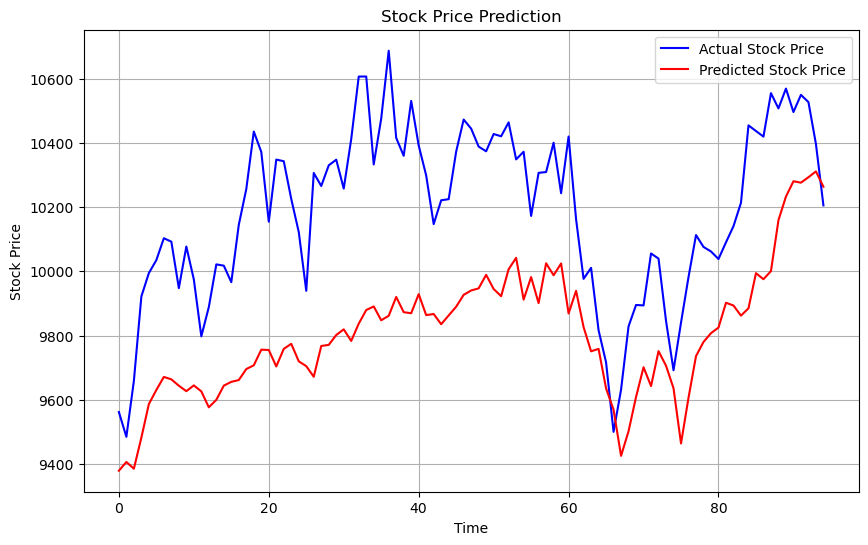

Root Mean Squared Error: 417.58999988732376
Mean Absolute Percentage Error: 0.03722806028443022


In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Get actual prices from the last part of the test set
actual_prices = data_test_copy['Close/Last'].values[seq_len:]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate RMSE
rmse = mean_squared_error(actual_prices, predicted_stock_price, squared=False)
print(f"Root Mean Squared Error: {rmse}")

mape = mean_absolute_percentage_error(actual_prices, predicted_stock_price)
print(f"Mean Absolute Percentage Error: {mape}")


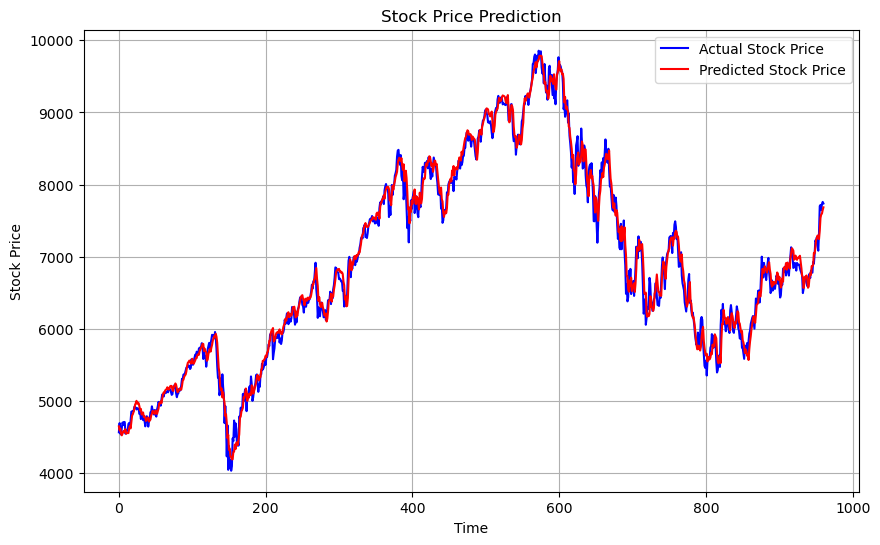

In [21]:
predicted_stock_price_train = predict_stock_price(model, X_train, scaler_price)
actual_prices_train = data_train_copy['Close/Last'].values[seq_len:]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual_prices_train, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price_train, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
torch.save(model.state_dict(), 'TransformerTech.pth')
import joblib
joblib.dump(scaler_price, 'scaler_price_techtransformer.pkl')
np.save('X_test_techtransformer.npy', X_test)